In [1]:
# libraries
import os
import getpass
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt

# Introduktion 
Formålet med denne kode ...

# Funktioner

## Header

In [5]:
def standardize_dates(df, date_column):
    """
    Standardizes a date column to a common monthly format (YYYY-MM-01).
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the date column.
    date_column (str): The name of the column containing date values.
    Returns:
    pd.DataFrame: The dataframe with a standardized date column.
    """
    
    # Make a copy of the dataframe to avoid modifying the original
    df = df.copy()
    
    # Convert to string in case of mixed formats
    df[date_column] = df[date_column].astype(str)
    
    # Handle daily format (YYYY-MM-DD) → Convert directly
    if df[date_column].str.match(r"^\d{4}-\d{2}-\d{2}$").all():
        df["Date"] = pd.to_datetime(df[date_column]).dt.to_period("M").dt.to_timestamp()

    # Handle monthly format (YYYY-MM) → Convert directly
    elif df[date_column].str.match(r"^\d{4}-\d{2}$").all():
        df["Date"] = pd.to_datetime(df[date_column] + "-01")
        
    # Handle monthly format (YYYYMM) → Convert directly
    elif df[date_column].str.match(r"^\d{4}\d{2}$").all():
        df["Date"] = pd.to_datetime(df[date_column] + "-01")
        
    # Handle daliy format (YYYYM0DD)
    elif df[date_column].str.match(r"^\d{4}M0\d{2}$").all():
        df["Date"] = pd.to_datetime(df[date_column].str[:4] + "-" + df[date_column].str[5:6] + "-" + df[date_column].str[-2:])

    # Handle monthly format (YYYYMM) → Convert correctly
    elif df[date_column].str.match(r"^\d{4}M\d{2}$").all():
        df["Date"] = pd.to_datetime(df[date_column].str[:4] + "-" + df[date_column].str[5:] + "-01")
        
    # Handle yearly format (YYYY) → Convert to first day of the year
    elif df[date_column].str.match(r"^\d{4}$").all():
        df["Date"] = pd.to_datetime(df[date_column] + "-01-01")
        
    # Handle format 'YYYYMXXDXX' (e.g., '2001M01D02' → '2001-01-02')
    elif df[date_column].str.match(r"^\d{4}M\d{2}D\d{2}$").all():
        df["Date"] = pd.to_datetime(
            df[date_column].str[:4] + "-" +  # Extract year
            df[date_column].str[5:7] + "-" +  # Extract month (skip 'M')
            df[date_column].str[-2:]  # Extract day (skip 'D')
        )

    # Handle quarterly format (YYYYKX) → Convert to first month of quarter
    elif df[date_column].str.match(r"^\d{4}K[1-4]$").all():
        df["Date"] = pd.to_datetime(
            df[date_column].str[:4] + "-" + 
            df[date_column].str[5].replace({"1": "01", "2": "04", "3": "07", "4": "10"}) + "-01"
        )
        
    elif df[date_column].str.match(r"^\d{4}K[1-4]$").all():
        quarter_map = {"1": "01", "2": "04", "3": "07", "4": "10"}
        df["Date"] = pd.to_datetime(
            df[date_column].str[:4] + "-" +
            df[date_column].str[5].map(quarter_map) + "-01"
        )

    
    else:
        raise ValueError("Unrecognized date format. Ensure the column is in daily (YYYY-MM-DD), monthly (YYYY-MM), or quarterly (YYYYKX) format.")
    
    # Drop the original date column and set the new Date column as index
    df = df.drop(columns=[date_column]).set_index("Date")
    
    return df

def save_merged_data(df, filename="merged_dataset.csv"):
    """
    Gemmer en dataframe som en CSV-fil.
    
    Parameters:
    df (pd.DataFrame): DataFrame der skal gemmes.
    filename (str): Navnet på den gemte CSV-fil (standard: "merged_dataset.csv").
    """
    df.to_csv(filename, sep=";", na_rep="NaN", index=True, encoding="utf-8")
    print(f"✅ Filen '{filename}' er gemt!")

    
def check_missing_values(df):
    missing_values = df.isna().sum()  # Antal NaN per kolonne
    total_missing = missing_values.sum()  # Samlet antal NaN
    missing_percent = (missing_values / len(df)) * 100  # Procentvis manglende værdier
    
    # Udlad for nu
    missing_df = pd.DataFrame({
        "Missing Values": missing_values,
        "Percentage (%)": missing_percent
    })
    
    print(f"Total missing values in dataset: {total_missing}")
    return 

## Import headers

In [7]:
# Gå et niveau op og naviger til mappen "Data"
os.chdir('Data')

# Læs headeren fra "header.csv"
header_path = 'header.csv'
header = pd.read_csv(header_path, sep=';', encoding='ISO-8859-1').columns.tolist()

## Niveau 0

In [9]:
# Åbn CSV-filen "niveau_0" som er semikolon-separeret og med encoding 'ISO-8859-1'
file_path = 'niveau_0.csv'
niveau_0 = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1',header=0)

niveau_0.replace("..", pd.NA, inplace=True)

# Kør standardiseringsfunktionen
df_niveau_0 = standardize_dates(niveau_0, "date")

# Se det nye dataset
df_niveau_0

,00 Forbrugerprisindekset i alt
Date,
2001-01-01,76.7
2001-02-01,77.3
2001-03-01,77.7
2001-04-01,78.0
2001-05-01,78.4
...,...
2024-10-01,119.6
2024-11-01,119.2
2024-12-01,118.9


In [10]:
check_missing_values(df_niveau_0)

Total missing values in dataset: 0


## Niveau 1

In [12]:
# Åbn CSV-filen "niveau_1" som er semikolon-separeret og med encoding 'ISO-8859-1'
file_path = 'niveau_1_new.csv'
niveau_1 = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1', header=0).dropna()
niveau_1.replace("..", pd.NA, inplace=True)

In [13]:
# Kør standardiseringsfunktionen
df_niveau_1 = standardize_dates(niveau_1, "date")
df_niveau_1

,01 Fødevarer og ikke-alkoholiske drikkevarer,02. Alkoholiske drikkevarer og tobak,03. Beklædning og fodtøj,"04. Boligbenyttelse, elektricitet og opvarmning","05. Møbler, husholdningsudstyr og husholdningstjenester",06. Sundhed,07. Transport,08. Kommunikation,09. Fritid og kultur,10. Uddannelse,11. Restauranter og hoteller,12. Andre varer og tjenester
Date,,,,,,,,,,,,
2001-01-01,75.2,76.3,88.9,69.4,84.7,81.2,77.7,130.4,96.7,49.8,70.4,68.1
2001-02-01,75.7,76.3,89.7,70.2,85.2,81.2,78.5,130.2,96.8,49.8,70.7,68.2
2001-03-01,76.2,76.4,97.4,70.1,85.5,81.2,78.4,129.7,96.9,49.8,70.8,68.5
2001-04-01,77.0,76.4,100.0,70.2,85.7,80.0,79.0,129.4,97.4,49.8,70.9,68.9
2001-05-01,77.5,76.5,100.1,70.2,85.8,80.0,80.0,129.1,98.3,49.8,71.2,69.4
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,132.4,135.0,99.7,120.2,101.6,113.8,118.7,84.9,116.3,134.6,133.7,120.1
2024-11-01,132.4,134.8,98.6,121.0,103.7,112.4,117.7,84.3,115.0,134.6,128.6,119.9
2024-12-01,129.7,132.5,98.5,120.7,104.1,113.8,117.6,85.9,113.8,134.6,131.6,119.9


In [14]:
check_missing_values(df_niveau_1)

Total missing values in dataset: 0


## Niveau 2

In [16]:
# First approch, I think it can be delete at some point...
""" # Åbn CSV-filen "niveau_2" som er semikolon-separeret og med encoding 'ISO-8859-1'
file_path = 'niveau_2_new.csv'
niveau_2 = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1', header=0, decimal=",")
niveau_2.replace("..", pd.NA, inplace=True)
niveau_2.head()

# Kør standardiseringsfunktionen
df_niveau_2 = standardize_dates(niveau_2, "date")
df_niveau_2

# Check Missing values
check_missing_values(df_niveau_2)

# Fjern kolonnen "01.1 Fødevarer"
#df_niveau_2 = df_niveau_2.drop(columns=["01.1 Fødevarer"])


# Print all for each columns the sum of NaNs
print(df_niveau_2.isna().sum())


# Hvis en række har mere en 70 pct NaN slettes den
# Ændre til 100pct
df_niveau_2.dropna(axis=1, thresh=len(df_niveau_2) * 1, inplace=True) """ 

' # Åbn CSV-filen "niveau_2" som er semikolon-separeret og med encoding \'ISO-8859-1\'\nfile_path = \'niveau_2_new.csv\'\nniveau_2 = pd.read_csv(file_path, sep=\';\', encoding=\'ISO-8859-1\', header=0, decimal=",")\nniveau_2.replace("..", pd.NA, inplace=True)\nniveau_2.head()\n\n# Kør standardiseringsfunktionen\ndf_niveau_2 = standardize_dates(niveau_2, "date")\ndf_niveau_2\n\n# Check Missing values\ncheck_missing_values(df_niveau_2)\n\n# Fjern kolonnen "01.1 Fødevarer"\n#df_niveau_2 = df_niveau_2.drop(columns=["01.1 Fødevarer"])\n\n\n# Print all for each columns the sum of NaNs\nprint(df_niveau_2.isna().sum())\n\n\n# Hvis en række har mere en 70 pct NaN slettes den\n# Ændre til 100pct\ndf_niveau_2.dropna(axis=1, thresh=len(df_niveau_2) * 1, inplace=True) '

In [17]:
file_path = 'niveau_2.xlsx'
niveau_2 = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
niveau_2 = standardize_dates(niveau_2, "date")

In [18]:
df_niveau_2 = niveau_2.resample("MS").ffill()
df_niveau_2  

,01.1 Fødevarer,01.2 Ikke-alkoholiske drikkevarer,02.1 Alkoholiske drikkevarer,02.2 Tobak,03.1 Beklædning,03.2 Fodtøj,04.1 Faktisk husleje,04.2 Beregnet lejeværdi af bolig,04.3 Vedligeholdelse og reparation af bolig,04.4 Vandforsyning og andre tjenester i forbindelse med boligen,...,10.4 Videregående uddannelse,10.5 Undervisning uden for niveau,"11.1 Restauranter, cafeer og kantiner mv.",11.2 Overnatningsfaciliteter,12.1 Personlig pleje,12.3 Andre personlige effekter,12.4 Daginstitutioner og social forsorg,12.5 Forsikring,12.6 Finansielle tjenester,12.7 Andre tjenester
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,74.7,79.4,88.9,66.8,96.6,61.5,69.7,69.6,73.9,60.2,...,NaN,NaN,69.7,82.0,78.4,72.3,70.6,62.1,62.3,66.1
2001-02-01,75.0,80.6,89.0,66.8,98.0,60.9,71.1,71.0,75.0,60.2,...,NaN,NaN,70.1,82.0,78.4,72.8,70.6,62.1,62.3,66.1
2001-03-01,75.6,81.1,89.2,66.8,107.8,62.6,71.1,71.0,75.1,60.2,...,NaN,NaN,70.2,82.0,79.1,73.9,70.6,62.1,62.3,66.4
2001-04-01,76.6,80.7,89.2,66.8,110.9,63.8,71.1,71.0,75.1,60.2,...,NaN,NaN,70.3,82.0,79.4,74.1,70.6,62.1,65.9,67.7
2001-05-01,77.1,80.6,89.3,66.8,110.9,63.9,71.1,71.0,75.5,60.2,...,NaN,NaN,70.4,85.6,79.5,74.5,70.6,63.5,66.2,67.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,134.1,119.5,114.1,157.0,95.8,115.8,115.2,115.6,133.7,125.8,...,127.7,131.6,131.5,142.2,103.7,101.9,130.4,123.4,127.4,124.8
2024-11-01,134.3,118.5,113.8,157.0,94.6,115.5,115.6,116.0,134.4,125.8,...,127.7,131.6,131.8,111.2,103.0,101.9,130.4,123.4,127.4,124.9
2024-12-01,131.7,115.4,110.2,157.3,94.6,114.6,115.6,116.0,134.8,125.8,...,127.7,131.6,132.0,127.5,102.7,102.5,130.4,123.4,127.9,124.9


## Inflation

In [20]:
file_path = 'cpi_inflation.xlsx'
cpi = pd.read_excel(file_path, header=0, decimal=",")
cpi

,date,cpi
0,2001M01,76.7
1,2001M02,77.3
2,2001M03,77.7
3,2001M04,78.0
4,2001M05,78.4
...,...,...
285,2024M10,119.6
286,2024M11,119.2
287,2024M12,118.9
288,2025M01,119.6


In [21]:
cpi = standardize_dates(cpi, "date")

In [22]:
# Beregn inflation som år-til-år ændring (i procent)
cpi["Inflation"] = ((cpi["cpi"] - cpi["cpi"].shift(12)) / cpi["cpi"].shift(12)) * 100

# Rund til 4 decimaler (valgfrit)
cpi["Inflation"] = cpi["Inflation"].round(3)

cpi = cpi.drop(columns=["cpi"])

df_inflation = cpi.copy()

In [23]:
df_inflation

,Inflation
Date,
2001-01-01,NaN
2001-02-01,NaN
2001-03-01,NaN
2001-04-01,NaN
2001-05-01,NaN
...,...
2024-10-01,1.614
2024-11-01,1.620
2024-12-01,1.885


### Lagged af inflation

In [25]:
# Antag, at din originale dataframe hedder 'df_inflation'
# og at kolonnen hedder som vist på billedet
colname = "Inflation"

# Hvor mange lags du vil have med
num_lags = 12

# Lav en kopi, så vi ikke ændrer det oprindelige
df_lagged_inflation = df_inflation[[colname]].copy()

# Lav laggede kolonner
for lag in range(1, num_lags + 1):
    df_lagged_inflation[f"inflation_lag{lag}"] = df_lagged_inflation[colname].shift(lag)
    
# Tilføj rullende gennemsnit (fx over de seneste 3 måneder)
#df_lagged_inflation["inflation_rolling_mean3"] = df_inflation[colname].rolling(window=3).mean()

# Fjern rækker med NaN (de første pga. lags)

df_lagged_inflation = df_lagged_inflation.dropna()
# Fjern target-kolonnen
df_lagged_inflation = df_lagged_inflation.drop(columns=["Inflation"])


# Se resultat
df_lagged_inflation

,inflation_lag1,inflation_lag2,inflation_lag3,inflation_lag4,inflation_lag5,inflation_lag6,inflation_lag7,inflation_lag8,inflation_lag9,inflation_lag10,inflation_lag11,inflation_lag12
Date,,,,,,,,,,,,
2003-01-01,2.548,2.810,2.548,2.423,2.305,2.177,2.171,2.041,2.564,2.574,2.458,2.477
2003-02-01,2.545,2.548,2.810,2.548,2.423,2.305,2.177,2.171,2.041,2.564,2.574,2.458
2003-03-01,2.778,2.545,2.548,2.810,2.548,2.423,2.305,2.177,2.171,2.041,2.564,2.574
2003-04-01,2.886,2.778,2.545,2.548,2.810,2.548,2.423,2.305,2.177,2.171,2.041,2.564
2003-05-01,2.375,2.886,2.778,2.545,2.548,2.810,2.548,2.423,2.305,2.177,2.171,2.041
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,1.278,1.359,1.097,1.804,2.155,0.765,0.938,0.766,1.203,0.690,0.600,0.085
2024-11-01,1.614,1.278,1.359,1.097,1.804,2.155,0.765,0.938,0.766,1.203,0.690,0.600
2024-12-01,1.620,1.614,1.278,1.359,1.097,1.804,2.155,0.765,0.938,0.766,1.203,0.690


## Brutto ledige

In [27]:
file_path = 'ledige.xlsx'
antal_ledige = pd.read_excel(file_path, header=0, decimal=",")

antal_ledige = standardize_dates(antal_ledige, "date")
df_antal_ledige = antal_ledige.resample("MS").ffill()
df_antal_ledige

,Bruttoledige,Ledige dagpengemodtagere,Ledige kontanthjælpsmodtagere
Date,,,
2007-01-01,119018.0,90915.5,28102.5
2007-02-01,115165.1,87461.5,27703.5
2007-03-01,110045.9,83156.5,26889.5
2007-04-01,108612.7,82269.8,26343.1
2007-05-01,105135.8,79468.4,25667.4
...,...,...,...
2024-10-01,88010.4,75429.7,12580.7
2024-11-01,88116.1,75548.4,12567.7
2024-12-01,87942.8,75474.8,12468.0


## Ledige i pct ( skal måske slettes?)

In [29]:
file_path = 'ledige_procent.xlsx'
ledige_procent = pd.read_excel(file_path, header=0, decimal=",")
#ledige.set_index("date", inplace=True)
ledige_procent

,date,Bruttoledige (i pct. af arbejdsstyrken)
0,2007M01,4.3
1,2007M02,4.1
2,2007M03,3.9
3,2007M04,3.9
4,2007M05,3.8
...,...,...
213,2024M10,2.9
214,2024M11,2.9
215,2024M12,2.9
216,2025M01,2.9


In [30]:
df_ledige_procent = standardize_dates(ledige_procent, "date")

df_ledige_procent = df_ledige_procent.resample("MS").ffill()
df_ledige_procent

,Bruttoledige (i pct. af arbejdsstyrken)
Date,
2007-01-01,4.3
2007-02-01,4.1
2007-03-01,3.9
2007-04-01,3.9
2007-05-01,3.8
...,...
2024-10-01,2.9
2024-11-01,2.9
2024-12-01,2.9


## Antal af fødte børn

In [32]:
file_path = 'fødte_børn.csv'

In [33]:
børn = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1', header=0)

børn = standardize_dates(børn, "year")

df_børn = børn.resample("MS").ffill()
df_børn.shape

(277, 2)

In [34]:
# Tilføj rækker frem til 2025-02-01
future_index = pd.date_range(start=df_børn.index.min(), end="2025-02-01", freq="MS")

# Reindex og ffill for at fylde manglende data
df_børn = df_børn.reindex(future_index).ffill()
df_børn.index.name = "Date"
df_børn

,F¿dte Drenge,F¿dte Piger
Date,,
2001-01-01,33497.0,31961.0
2001-02-01,33497.0,31961.0
2001-03-01,33497.0,31961.0
2001-04-01,33497.0,31961.0
2001-05-01,33497.0,31961.0
...,...,...
2024-10-01,29501.0,27578.0
2024-11-01,29501.0,27578.0
2024-12-01,29501.0,27578.0


## Econ indikator

In [36]:
file_path = 'econ_indikator.xlsx'
econ_indikator = pd.read_excel(file_path, header=0, decimal=",")
econ_indikator

,date,"B.1*g Bruttonationalprodukt, BNP",P.7 Import af varer og tjenester,P.71 Import af varer,P.72 Import af tjenester,Forsyning i alt,P.6 Eksport af varer og tjenester,P.61 Eksport af varer,P.62 Eksport af tjenester,P.31 Privatforbrug,...,N.112 Andre bygninger og anlæg,"N.113-N.115 Maskiner, transportmidler mv.",N.117 Intellektuelle rettigheder,P.52+P.53 Lagerforøgelser mv.,P.52 Lagerforøgelser,P.53 Anskaffelser minus afhændelser af værdigenstande,Endelig indenlandsk anvendelse,Endelig anvendelse i alt,Samlede præsterede timer (mio. timer),Samlet antal beskæftigede (1000 personer)
0,2001K1,337.7,131.1,88.8,42.3,468.8,159.1,104.4,54.7,158.2,...,18.2,25.9,12.0,0.6,0.2,0.4,310.2,469.3,1024.7,2781.6
1,2001K2,340.8,135.3,91.5,43.8,476.2,158.7,104.0,54.7,161.5,...,18.6,27.7,12.7,-0.7,-1.2,0.5,316.9,475.6,1029.1,2786.8
2,2001K3,344.9,131.3,89.5,41.8,476.2,154.2,103.7,50.5,161.8,...,19.3,26.0,12.8,3.5,3.0,0.5,322.5,476.7,1018.4,2777.8
3,2001K4,348.9,129.7,88.7,41.0,478.6,153.3,102.5,50.8,160.6,...,19.5,27.4,13.4,3.2,2.8,0.4,324.8,478.1,1014.4,2783.7
4,2002K1,348.7,138.4,91.9,46.6,487.1,160.4,106.0,54.3,163.8,...,18.5,28.0,12.9,1.5,1.0,0.6,325.8,486.2,1012.5,2780.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2023K4,699.2,424.2,228.7,195.5,1123.5,481.9,280.8,201.1,328.9,...,39.4,28.6,43.6,1.1,0.1,1.0,640.1,1121.9,1107.3,3210.1
92,2024K1,711.3,420.9,228.7,192.2,1132.2,484.2,280.4,203.8,330.0,...,40.4,32.2,43.6,-7.4,-8.5,1.0,640.0,1124.2,1116.6,3221.9
93,2024K2,723.1,429.0,229.4,199.6,1152.1,502.3,287.0,215.2,331.6,...,41.6,33.6,44.1,-3.1,-4.1,1.0,653.9,1156.2,1108.6,3225.3
94,2024K3,748.6,430.6,231.6,198.9,1179.2,524.4,299.7,224.7,332.8,...,42.8,33.7,44.8,-3.9,-4.9,1.0,660.1,1184.5,1109.6,3228.5


In [37]:
econ_indikator = standardize_dates(econ_indikator, "date")

In [38]:
df_econ_indikator = econ_indikator.resample("MS").ffill()
df_econ_indikator.shape

(286, 31)

In [39]:
# Tilføj rækker frem til 2025-02-01
future_index = pd.date_range(start=df_econ_indikator.index.min(), end="2025-02-01", freq="MS")

# Reindex og ffill for at fylde manglende data
df_econ_indikator = df_econ_indikator.reindex(future_index).ffill()
df_econ_indikator.index.name = "Date"
df_econ_indikator

,"B.1*g Bruttonationalprodukt, BNP",P.7 Import af varer og tjenester,P.71 Import af varer,P.72 Import af tjenester,Forsyning i alt,P.6 Eksport af varer og tjenester,P.61 Eksport af varer,P.62 Eksport af tjenester,P.31 Privatforbrug,P.31 Husholdningernes forbrugsudgifter,...,N.112 Andre bygninger og anlæg,"N.113-N.115 Maskiner, transportmidler mv.",N.117 Intellektuelle rettigheder,P.52+P.53 Lagerforøgelser mv.,P.52 Lagerforøgelser,P.53 Anskaffelser minus afhændelser af værdigenstande,Endelig indenlandsk anvendelse,Endelig anvendelse i alt,Samlede præsterede timer (mio. timer),Samlet antal beskæftigede (1000 personer)
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,337.7,131.1,88.8,42.3,468.8,159.1,104.4,54.7,158.2,152.9,...,18.2,25.9,12.0,0.6,0.2,0.4,310.2,469.3,1024.7,2781.6
2001-02-01,337.7,131.1,88.8,42.3,468.8,159.1,104.4,54.7,158.2,152.9,...,18.2,25.9,12.0,0.6,0.2,0.4,310.2,469.3,1024.7,2781.6
2001-03-01,337.7,131.1,88.8,42.3,468.8,159.1,104.4,54.7,158.2,152.9,...,18.2,25.9,12.0,0.6,0.2,0.4,310.2,469.3,1024.7,2781.6
2001-04-01,340.8,135.3,91.5,43.8,476.2,158.7,104.0,54.7,161.5,156.2,...,18.6,27.7,12.7,-0.7,-1.2,0.5,316.9,475.6,1029.1,2786.8
2001-05-01,340.8,135.3,91.5,43.8,476.2,158.7,104.0,54.7,161.5,156.2,...,18.6,27.7,12.7,-0.7,-1.2,0.5,316.9,475.6,1029.1,2786.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,769.2,438.8,236.8,202.0,1208.0,552.2,322.5,229.7,337.2,325.9,...,42.8,33.6,45.8,-17.9,-18.8,0.9,654.5,1206.7,1114.5,3240.3
2024-11-01,769.2,438.8,236.8,202.0,1208.0,552.2,322.5,229.7,337.2,325.9,...,42.8,33.6,45.8,-17.9,-18.8,0.9,654.5,1206.7,1114.5,3240.3
2024-12-01,769.2,438.8,236.8,202.0,1208.0,552.2,322.5,229.7,337.2,325.9,...,42.8,33.6,45.8,-17.9,-18.8,0.9,654.5,1206.7,1114.5,3240.3


### Valutakurser

In [41]:
file_path = 'valutakurser.xlsx'

In [42]:
Valutakurser = pd.read_excel(file_path, header=0, decimal=",")

In [43]:
Valutakurser = standardize_dates(Valutakurser, "date")

In [44]:
df_valutakurser = Valutakurser.resample("MS").ffill()
df_valutakurser

,EUR Euro (Jan. 1999-),USD Amerikanske dollar (Jan. 1979-),GBP Britiske pund (Jan. 1981-),SEK Svenske kroner (Jan. 1980-)
Date,,,,
2001-01-01,746.4373,795.0623,1175.5700,83.8845
2001-02-01,746.3120,809.4930,1176.8350,83.1745
2001-03-01,746.4391,820.6772,1186.0940,81.7718
2001-04-01,746.3239,835.9222,1199.7760,81.8889
2001-05-01,746.1628,852.5195,1215.6630,82.3338
...,...,...,...,...
2024-10-01,745.9265,684.1126,893.3804,65.4065
2024-11-01,745.8276,701.7319,894.5195,64.3914
2024-12-01,745.8878,711.1756,900.8617,64.8328


### Transaktioner med kort

In [46]:
file_path = 'transaktioner_medkort.xlsx'
transaktioner_medkort = pd.read_excel(file_path, header=0, decimal=",")
transaktioner_medkort.shape

(2253, 3)

In [47]:
transaktioner_medkort = standardize_dates(transaktioner_medkort, "date")

In [48]:
df_transaktioner_medkort = transaktioner_medkort.resample("MS").ffill()
df_transaktioner_medkort

,Transaktioner - Værdi (kr.),Antal transaktioner med kort (stk.)
Date,,
2019-01-01,532818728,2324456
2019-02-01,1876394477,6817359
2019-03-01,1954701700,7097706
2019-04-01,1563414384,5740496
2019-05-01,1805399506,6516506
...,...,...
2024-11-01,2538732203,9204718
2024-12-01,2226184670,8256522
2025-01-01,1112985682,4235434


### antal_ejendomsalg

In [50]:
file_path = 'ejdendom_antalsalg.xlsx'
ejendomsalg = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
ejendomsalg = standardize_dates(ejendomsalg, "date")

In [51]:
df_ejendomsalg = ejendomsalg.resample("MS").ffill()
df_ejendomsalg

,Total salg af Enfamiliehuse,Total salg af Sommerhuse,Total salg af Ejerlejligheder
Date,,,
2005-01-01,14398,2915,6104
2005-02-01,14398,2915,6104
2005-03-01,14398,2915,6104
2005-04-01,15155,3141,6602
2005-05-01,15155,3141,6602
...,...,...,...
2024-03-01,11822,1995,3171
2024-04-01,12834,2140,4049
2024-05-01,12834,2140,4049


## Medlemer af Folkekirken

In [53]:
file_path = 'medlemer_folkekirken.csv'
folkekirken_medlemmer = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1', header=0)

# Kør standardiseringsfunktionen
folkekirken_medlemmer = standardize_dates(folkekirken_medlemmer, "date")

In [54]:
df_folkekirken_medlemmer= folkekirken_medlemmer.resample("MS").ffill()
df_folkekirken_medlemmer

,Medlemmer af Folkekirken
Date,
2007-01-01,4499343
2007-02-01,4499343
2007-03-01,4499343
2007-04-01,4496926
2007-05-01,4496926
...,...
2024-09-01,4245853
2024-10-01,4241820
2024-11-01,4241820


## Antal Totale Skilsmisser

In [56]:
file_path = 'total_skilsmisser.csv'
total_skilsmisser = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1', header=0)

# Kør standardiseringsfunktionen
total_skilsmisser = standardize_dates(total_skilsmisser, "date")

In [57]:
df_total_skilsmisser = total_skilsmisser.resample("MS").ffill()
df_total_skilsmisser

,Antal Skilsmisser
Date,
2001-01-01,14692
2001-02-01,14692
2001-03-01,14692
2001-04-01,14692
2001-05-01,14692
...,...
2023-09-01,12862
2023-10-01,12862
2023-11-01,12862


## Vielser

In [59]:
file_path = 'vielser.xlsx'
vielser = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
vielser = standardize_dates(vielser, "year")

In [60]:
df_vielser = vielser.resample("MS").ffill()
df_vielser

,Gennemsnitsalder for 1. gangsviede mænd,Gennemsnitsalder for 1. gangsviede kvinder,Vielser i alt
Date,,,
2001-01-01,32.8,30.3,36909
2001-02-01,32.8,30.3,36909
2001-03-01,32.8,30.3,36909
2001-04-01,32.8,30.3,36909
2001-05-01,32.8,30.3,36909
...,...,...,...
2023-09-01,35.9,33.7,31582
2023-10-01,35.9,33.7,31582
2023-11-01,35.9,33.7,31582


## total_hustande

In [62]:
file_path = 'total_hustande.csv'
total_hustande = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1', header=0)

# Kør standardiseringsfunktionen
total_hustande = standardize_dates(total_hustande, "year")

In [63]:
df_total_hustande = total_hustande.resample("MS").ffill()
df_total_hustande

,"Hustande, Hele landet"
Date,
2001-01-01,2448490
2001-02-01,2448490
2001-03-01,2448490
2001-04-01,2448490
2001-05-01,2448490
...,...
2024-09-01,2834240
2024-10-01,2834240
2024-11-01,2834240


## Fertilitetskvotienter

In [65]:
file_path = 'Fertilitetskvotienter.xlsx'
Fertilitetskvotienter = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
Fertilitetskvotienter = standardize_dates(Fertilitetskvotienter, "year")

In [66]:
df_fertilitetskvotienter = Fertilitetskvotienter.resample("MS").ffill()
df_fertilitetskvotienter

,Samlet fertilitet
Date,
2001-01-01,1745.0
2001-02-01,1745.0
2001-03-01,1745.0
2001-04-01,1745.0
2001-05-01,1745.0
...,...
2023-09-01,1495.9
2023-10-01,1495.9
2023-11-01,1495.9


## Implicit Lønindeks

In [68]:
file_path = 'Implicit_lønindeks.xlsx'
implicit_lønindeks = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
implicit_lønindeks = standardize_dates(implicit_lønindeks, "date")

In [69]:
df_implicit_lønindeks = implicit_lønindeks.resample("MS").ffill()
df_implicit_lønindeks = df_implicit_lønindeks.add_prefix("Implicit_lønindeks_")


In [70]:
df_implicit_lønindeks

,Implicit_lønindeks_Forskning og udvikling,Implicit_lønindeks_P Undervisning,Implicit_lønindeks_R Kultur og fritid,"Implicit_lønindeks_2 Industri, råstofindvinding og forsyningsvirksomhed",Implicit_lønindeks_3 Bygge og anlæg,Implicit_lønindeks_4 Handel og transport mv.,Implicit_lønindeks_5 Information og kommunikation,Implicit_lønindeks_6 Finansiering og forsikring,Implicit_lønindeks_7 Ejendomshandel og udlejning,Implicit_lønindeks_8 Erhvervsservice,"Implicit_lønindeks_10 Kultur, fritid og anden service"
Date,,,,,,,,,,,
2005-01-01,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2005-02-01,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2005-03-01,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2005-04-01,103.9,103.3,102.1,100.4,100.2,100.6,100.7,100.7,100.6,100.4,100.6
2005-05-01,103.9,103.3,102.1,100.4,100.2,100.6,100.7,100.7,100.6,100.4,100.6
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01,158.5,162.1,159.6,167.1,159.9,154.0,159.3,173.2,157.6,161.0,140.5
2024-07-01,159.3,162.4,161.1,167.0,158.9,154.1,160.3,174.8,158.0,162.5,141.1
2024-08-01,159.3,162.4,161.1,167.0,158.9,154.1,160.3,174.8,158.0,162.5,141.1


## antal_beskæftigede

In [72]:
file_path = 'antal_beskæftigede.xlsx'
antal_beskæftigede = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
antal_beskæftigede = standardize_dates(antal_beskæftigede, "year")

In [73]:
df_antal_beskæftigede = antal_beskæftigede.resample("MS").ffill()
df_antal_beskæftigede  # Se de første 12 måneder

,Beskæftigede Mænd,Beskæftigede Kvinder
Date,,
2008-01-01,1493769,1351045
2008-02-01,1493769,1351045
2008-03-01,1493769,1351045
2008-04-01,1493769,1351045
2008-05-01,1493769,1351045
...,...,...
2022-09-01,1618463,1471748
2022-10-01,1618463,1471748
2022-11-01,1618463,1471748


## Forbrugerforventninger

In [75]:
file_path = 'Forbrugerforventninger.xlsx'
Forbrugerforventninger = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
Forbrugerforventninger = standardize_dates(Forbrugerforventninger, "date")

In [76]:
df_forbrugerforventninger = Forbrugerforventninger.resample("MS").ffill()
df_forbrugerforventninger  # Se de første 12 måneder

,Forbrugertillidsindikatoren,"Familiens økonomiske situation i dag, sammenlignet med for et år siden","Familiens økonomiske situation om et år, sammenlignet med i dag","Danmarks økonomiske situation i dag, sammenlignet med for et år siden","Danmarks økonomiske situation om et år, sammenlignet med i dag","Anskaffelse af større forbrugsgoder, fordelagtigt for øjeblikket","Priser i dag, sammenlignet med for et år siden","Priser om et år, sammenlignet med i dag","Arbejdsløsheden om et år, sammenlignet med i dag","Anskaffelse af større forbrugsgoder, inden for de næste 12 mdr.",Anser det som fornuftigt at spare op i den nuværende økonomiske situation,Regner med at kunne spare op i de kommende 12 måneder,Familiens økonomiske situation lige nu: kan spare/penge slår til/ bruger mere end man tjener
Date,,,,,,,,,,,,,
2001-01-01,3.0,7.0,13.0,3.0,-3.0,-3.0,-13.0,-12.0,0.0,-7.0,69.0,25.0,25.0
2001-02-01,1.0,3.0,17.0,0.0,-4.0,-9.0,-12.0,-11.0,-2.0,-6.0,74.0,26.0,22.0
2001-03-01,0.0,3.0,13.0,-3.0,-8.0,-6.0,-15.0,-10.0,1.0,-9.0,76.0,32.0,27.0
2001-04-01,-2.0,4.0,14.0,-9.0,-9.0,-10.0,-14.0,-11.0,5.0,-6.0,72.0,23.0,24.0
2001-05-01,0.0,8.0,12.0,-5.0,-6.0,-9.0,-7.0,-7.0,3.0,-6.0,73.0,30.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,-8.9,-8.9,-1.0,-9.8,-8.5,-16.1,28.0,21.0,10.2,-8.0,65.3,26.1,26.9
2024-11-01,-9.3,-10.1,0.0,-12.5,-10.9,-13.1,27.4,23.2,13.7,-3.7,67.2,30.1,25.3
2024-12-01,-13.1,-11.2,-1.2,-17.2,-18.0,-18.0,31.6,29.6,13.0,-7.5,65.0,26.8,24.0


## Befolkningens udvikling

In [78]:
file_path = 'befolkningens_udvikling.xlsx'
befolkningens_udvikling = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
befolkningens_udvikling = standardize_dates(befolkningens_udvikling, "date")

In [79]:
df_befolkningens_udvikling = befolkningens_udvikling.resample("MS").ffill()
df_befolkningens_udvikling  # Se de første 12 måneder

,Befolkningen ultimo forrige kvartal,Levendefødte,Døde,Fødselsoverskud,Tilflyttede,Fraflyttede,Nettotilflyttede,Indvandrede i alt,Indvandret i indeværende kvartal,Indvandret før indeværende kvartal,Udvandrede i alt,Udvandret i indeværende kvartal,Udvandret før indeværende kvartal,Nettoindvandrede,Korrektioner,Befolkningstilvækst,Befolkningen ultimo indeværende kvartal
Date,,,,,,,,,,,,,,,,,
2007-04-01,5451995,15867,13579,2288,61780,61780,0,12722,12178,544,9330,9330,0,3392,-253,5427,5457422
2007-05-01,5451995,15867,13579,2288,61780,61780,0,12722,12178,544,9330,9330,0,3392,-253,5427,5457422
2007-06-01,5451995,15867,13579,2288,61780,61780,0,12722,12178,544,9330,9330,0,3392,-253,5427,5457422
2007-07-01,5457422,17177,13037,4140,92588,92588,0,24161,23384,777,14099,14099,0,10062,-715,13487,5470909
2007-08-01,5457422,17177,13037,4140,92588,92588,0,24161,23384,777,14099,14099,0,10062,-715,13487,5470909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01,5967824,14351,13580,771,71563,71563,0,19464,18235,1229,15394,11172,4222,4070,-245,4596,5972420
2024-07-01,5972420,14942,13701,1241,100951,100951,0,37612,35622,1990,21049,16009,5040,16563,-239,17565,5989985
2024-08-01,5972420,14942,13701,1241,100951,100951,0,37612,35622,1990,21049,16009,5040,16563,-239,17565,5989985


## Antal på kontanthjælp

In [81]:
file_path = 'antal_kontanthjælp.xlsx'
antal_kontanthjælp = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
antal_kontanthjælp = standardize_dates(antal_kontanthjælp, "date")

df_antal_kontanthjælp = antal_kontanthjælp.resample("MS").ffill()
df_antal_kontanthjælp  # Se de første 12 måneder

,"Kontanthjælp, I alt"
Date,
2007-01-01,125820
2007-02-01,124115
2007-03-01,123046
2007-04-01,121673
2007-05-01,120474
...,...
2024-08-01,88837
2024-09-01,88768
2024-10-01,88742


## Antal overtrædelse

In [83]:
file_path = 'antal_overtrædelse.xlsx'
antal_overtrædelse = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
antal_overtrædelse = standardize_dates(antal_overtrædelse, "date")

df_antal_overtrædelse = antal_overtrædelse.resample("MS").ffill()
df_antal_overtrædelse  # Se de første 12 måneder

,Overtrædelsens art i alt,Straffelov i alt,Seksualforbrydelser i alt,Voldsforbrydelser i alt,Ejendomsforbrydelser i alt,Særlove i alt
Date,,,,,,
2001-01-01,127582,111675,627,3629,105565,15907
2001-02-01,127582,111675,627,3629,105565,15907
2001-03-01,127582,111675,627,3629,105565,15907
2001-04-01,132619,116253,637,3994,109886,16366
2001-05-01,132619,116253,637,3994,109886,16366
...,...,...,...,...,...,...
2024-06-01,116061,85050,2145,7346,71908,31011
2024-07-01,112860,83807,1938,6945,71727,29053
2024-08-01,112860,83807,1938,6945,71727,29053


## PPI Samlet Dansk produktion

In [85]:
file_path = 'PPI_samlet_DK.xlsx'
PPI = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
PPI_data = standardize_dates(PPI, "date")
PPI_data

,"BCDE Råstofindvinding, Industri, Energi- og Vandforsyning",BC Råstofindvinding og industri,B Råstofindvinding,C Fremstillingsvirksomhed,10 Fremstilling af fødevarer,101 Forarbejdning og konservering af kød og produktion af kødprodukter,"102 Forarbejdning og konservering af fisk, krebsdyr og bløddyr",105 Fremstilling af mejeriprodukter,107 Fremstilling af bageri- og dejprodukter,108 Fremstilling af andre fødevarer,...,32 Anden fremstillingsvirksomhed,"D El-, gas- og fjernvarmeforsyning",S1 Investeringsgodeindustri,S2 Mellemproduktindustri,S3 Fremstilling af varige forbrugsgoder,S4 Fremstilling af ikke-varige forbrugsgoder,S5 Fremstilling af energiprodukter og energiforsyning,"C33 Fremstillingsindustri ekskl. forarb. af kød og fisk samt ekskl. fremst. af tobak, koks og raffinerede mineral olieprodukter",S6 Fremstilling af forbrugsgoder ekskl. fødevarer,Unnamed: 39
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-01,1.3,0.7,5.4,0.3,-0.5,0.0,-5.1,-0.1,-0.1,0.1,...,0.0,NaN,NaN,0.0,0.1,-0.1,-0.2,5.7,NaN,NaN
2005-03-01,2.5,1.4,10.3,0.0,-0.3,0.6,-0.2,-0.8,-0.7,-0.8,...,-1.5,NaN,NaN,-0.1,0.0,-0.3,0.0,10.8,NaN,NaN
2005-04-01,0.8,1.0,5.5,0.4,-0.4,-0.5,-0.3,0.0,-0.7,-0.6,...,0.1,NaN,NaN,0.4,-0.1,-0.1,-0.2,3.5,NaN,NaN
2005-05-01,0.0,-0.3,-2.6,-0.1,0.4,-1.2,3.0,0.5,0.7,0.6,...,-0.7,NaN,NaN,0.4,0.3,0.1,0.1,-0.8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,3.5,2.4,2.5,2.3,0.2,NaN,0.1,NaN,1.0,0.2,...,0.0,16.0,0.0,0.7,0.3,0.1,4.5,10.2,2.6,6.3
2024-12-01,1.3,1.4,1.1,1.5,0.9,NaN,1.6,NaN,0.2,0.4,...,0.2,-0.3,-0.1,0.1,0.4,0.0,2.6,0.8,1.4,3.2
2025-01-01,-0.1,-0.6,1.7,-0.8,0.8,NaN,2.7,NaN,0.1,0.1,...,-0.9,4.7,5.5,0.4,0.2,0.8,-3.1,5.4,-1.3,-5.5


In [86]:
df_PPI_data = PPI_data.resample("MS").ffill()
df_PPI_data = df_PPI_data.add_prefix("PPI_domestic_")
df_PPI_data  # Se de første 12 måneder

,"PPI_domestic_BCDE Råstofindvinding, Industri, Energi- og Vandforsyning",PPI_domestic_BC Råstofindvinding og industri,PPI_domestic_B Råstofindvinding,PPI_domestic_C Fremstillingsvirksomhed,PPI_domestic_10 Fremstilling af fødevarer,PPI_domestic_101 Forarbejdning og konservering af kød og produktion af kødprodukter,"PPI_domestic_102 Forarbejdning og konservering af fisk, krebsdyr og bløddyr",PPI_domestic_105 Fremstilling af mejeriprodukter,PPI_domestic_107 Fremstilling af bageri- og dejprodukter,PPI_domestic_108 Fremstilling af andre fødevarer,...,PPI_domestic_32 Anden fremstillingsvirksomhed,"PPI_domestic_D El-, gas- og fjernvarmeforsyning",PPI_domestic_S1 Investeringsgodeindustri,PPI_domestic_S2 Mellemproduktindustri,PPI_domestic_S3 Fremstilling af varige forbrugsgoder,PPI_domestic_S4 Fremstilling af ikke-varige forbrugsgoder,PPI_domestic_S5 Fremstilling af energiprodukter og energiforsyning,"PPI_domestic_C33 Fremstillingsindustri ekskl. forarb. af kød og fisk samt ekskl. fremst. af tobak, koks og raffinerede mineral olieprodukter",PPI_domestic_S6 Fremstilling af forbrugsgoder ekskl. fødevarer,PPI_domestic_Unnamed: 39
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-01,1.3,0.7,5.4,0.3,-0.5,0.0,-5.1,-0.1,-0.1,0.1,...,0.0,NaN,NaN,0.0,0.1,-0.1,-0.2,5.7,NaN,NaN
2005-03-01,2.5,1.4,10.3,0.0,-0.3,0.6,-0.2,-0.8,-0.7,-0.8,...,-1.5,NaN,NaN,-0.1,0.0,-0.3,0.0,10.8,NaN,NaN
2005-04-01,0.8,1.0,5.5,0.4,-0.4,-0.5,-0.3,0.0,-0.7,-0.6,...,0.1,NaN,NaN,0.4,-0.1,-0.1,-0.2,3.5,NaN,NaN
2005-05-01,0.0,-0.3,-2.6,-0.1,0.4,-1.2,3.0,0.5,0.7,0.6,...,-0.7,NaN,NaN,0.4,0.3,0.1,0.1,-0.8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,3.5,2.4,2.5,2.3,0.2,NaN,0.1,NaN,1.0,0.2,...,0.0,16.0,0.0,0.7,0.3,0.1,4.5,10.2,2.6,6.3
2024-12-01,1.3,1.4,1.1,1.5,0.9,NaN,1.6,NaN,0.2,0.4,...,0.2,-0.3,-0.1,0.1,0.4,0.0,2.6,0.8,1.4,3.2
2025-01-01,-0.1,-0.6,1.7,-0.8,0.8,NaN,2.7,NaN,0.1,0.1,...,-0.9,4.7,5.5,0.4,0.2,0.8,-3.1,5.4,-1.3,-5.5


## PPI Import

In [88]:
file_path = 'PPI_import.xlsx'
PPI_import = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
PPI_import_data = standardize_dates(PPI_import, "date")

Df_PPI_import_data = PPI_import_data.resample("MS").ffill()
Df_PPI_import_data = Df_PPI_import_data.add_prefix("PPI_import_")
Df_PPI_import_data  # Se de første 12 måneder

,"PPI_import_BCDE Råstofindvinding, Industri, Energi- og Vandforsyning",PPI_import_BC Råstofindvinding og industri,PPI_import_B Råstofindvinding,PPI_import_C Fremstillingsvirksomhed,PPI_import_10 Fremstilling af fødevarer,PPI_import_101 Forarbejdning og konservering af kød og produktion af kødprodukter,"PPI_import_102 Forarbejdning og konservering af fisk, krebsdyr og bløddyr",PPI_import_105 Fremstilling af mejeriprodukter,PPI_import_107 Fremstilling af bageri- og dejprodukter,PPI_import_108 Fremstilling af andre fødevarer,...,PPI_import_31 Fremstilling af møbler,PPI_import_32 Anden fremstillingsvirksomhed,"PPI_import_D El-, gas- og fjernvarmeforsyning",PPI_import_S1 Investeringsgodeindustri,PPI_import_S2 Mellemproduktindustri,PPI_import_S3 Fremstilling af varige forbrugsgoder,PPI_import_S4 Fremstilling af ikke-varige forbrugsgoder,PPI_import_S5 Fremstilling af energiprodukter og energiforsyning,"PPI_import_C33 Fremstillingsindustri ekskl. forarb. af kød og fisk samt ekskl. fremst. af tobak, koks og raffinerede mineral olieprodukter",PPI_import_S6 Fremstilling af forbrugsgoder ekskl. fødevarer
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-01,0.5,0.5,3.4,0.1,1.3,NaN,NaN,NaN,NaN,NaN,...,-0.1,0.3,20.5,0.4,0.0,0.2,0.6,4.4,NaN,NaN
2005-03-01,1.0,0.7,11.5,0.6,1.0,NaN,NaN,NaN,NaN,NaN,...,1.4,0.4,16.8,-0.7,0.1,0.7,0.5,14.4,NaN,NaN
2005-04-01,-0.2,-0.2,0.4,-0.1,0.2,NaN,NaN,NaN,NaN,NaN,...,0.0,-0.4,-7.2,-0.1,-0.3,0.0,0.0,-2.0,NaN,NaN
2005-05-01,0.0,0.0,-4.2,0.1,-0.6,NaN,NaN,NaN,NaN,NaN,...,0.6,-0.1,-3.5,-0.7,0.5,0.4,-0.2,1.3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,0.9,0.6,2.2,0.6,0.4,-0.4,-0.3,2.1,-0.6,0.8,...,0.1,0.5,82.0,0.6,0.2,0.0,0.7,6.2,0.4,0.6
2024-12-01,0.2,0.3,0.2,0.2,0.0,0.1,1.4,0.8,-0.1,-0.7,...,0.2,0.6,-0.9,0.3,0.3,0.2,-0.2,0.7,0.2,-0.2
2025-01-01,0.8,0.6,4.9,0.3,0.8,-0.7,-0.4,0.9,1.6,1.7,...,2.2,0.1,5.2,-0.2,-0.1,0.5,0.6,5.0,0.2,0.4


## Bil data

In [90]:
file_path = 'bil_data.xlsx'
bil_data = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
bil_data = standardize_dates(bil_data, "date")

df_bil_data = bil_data.resample("MS").ffill()
df_bil_data  # Se de første 12 måneder

,Personbiler i alt,"Tilgang af personbiler i alt, sæsonkorrigeret",Tilgang til husholdningerne,"Tilgang til husholdningerne, sæsonkorrigeret",Personbiler i husholdningerne,Privatleasing,Tilgang til erhvervene,"Tilgang til erhvervene, sæsonkorrigeret",Erhvervenes køb af personbiler,Erhvervsleasing,Leasingbiler i alt
Date,,,,,,,,,,,
2007-01-01,11684,12154,8250,8033,8015,235,3434,4122,1955,1479,1714
2007-02-01,10810,12732,6974,7984,6760,214,3836,4748,2003,1833,2047
2007-03-01,14443,13020,9481,8155,9200,281,4962,4866,2762,2200,2481
2007-04-01,12274,12552,8286,8037,8077,209,3988,4515,2102,1886,2095
2007-05-01,14342,12854,9369,8272,9093,276,4973,4582,2850,2123,2399
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,14385,15101,8745,9214,5222,3523,5640,5887,831,4809,8332
2024-11-01,14955,14924,8700,9122,5359,3341,6255,5802,750,5505,8846
2024-12-01,17431,14905,9728,8768,5701,4027,7703,6137,893,6810,10837


## Konjunkturbarometer

In [92]:
file_path = 'Konjunkturbarometer.xlsx'
konjunkturbarometer = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
konjunkturbarometer_data = standardize_dates(konjunkturbarometer, "date")

df_konjunkturbarometer = konjunkturbarometer_data.resample("MS").ffill()
df_konjunkturbarometer  # Se de første 12 måneder

,Tillidsindikator for industri,Tillidsindikator for bygge og anlæg,Tillidsindikator for detailhandel,Tillidsindikator for serviceerhverv
Date,,,,
2001-01-01,104.6,98.8,93.4,103.1
2001-02-01,103.7,96.8,93.3,102.1
2001-03-01,105.2,95.7,83.7,100.6
2001-04-01,96.1,97.9,89.6,98.2
2001-05-01,95.9,95.4,84.7,99.9
...,...,...,...,...
2024-12-01,104.8,104.3,103.6,104.8
2025-01-01,105.3,102.9,94.6,104.5
2025-02-01,107.3,101.6,102.5,107.0


## total energi produktion

In [94]:
file_path = 'Energi_data.xlsx'
energi_data = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
energi_data = standardize_dates(energi_data, "year")

df_energi_data = energi_data.resample("MS").ffill()
df_energi_data  # Se de første 12 måneder

,Total,Oil,Natural Gas,Coal and Coke,"Waste, Non-renewable 2)",Renewable Energy 3),"Electricity Import, Net"
Date,,,,,,,
2005-01-01,838813.500833,352523.131082,187220.096164,155255.093500,17006.34,121877.068925,4931.771162
2005-02-01,838813.500833,352523.131082,187220.096164,155255.093500,17006.34,121877.068925,4931.771162
2005-03-01,838813.500833,352523.131082,187220.096164,155255.093500,17006.34,121877.068925,4931.771162
2005-04-01,838813.500833,352523.131082,187220.096164,155255.093500,17006.34,121877.068925,4931.771162
2005-05-01,838813.500833,352523.131082,187220.096164,155255.093500,17006.34,121877.068925,4931.771162
...,...,...,...,...,...,...,...
2023-09-01,691190.009378,280334.613725,55972.345225,27945.351829,17349.33,298308.090000,11280.278599
2023-10-01,691190.009378,280334.613725,55972.345225,27945.351829,17349.33,298308.090000,11280.278599
2023-11-01,691190.009378,280334.613725,55972.345225,27945.351829,17349.33,298308.090000,11280.278599


## Detailomsætningsindeks

In [96]:
file_path = 'Detailomsætningsindeks.xlsx'
detailomsætningsindeks = pd.read_excel(file_path, header=0, decimal=",")

# Kør standardiseringsfunktionen
detailomsætningsindeks_data = standardize_dates(detailomsætningsindeks, "date")
detailomsætningsindeks_data.rename(columns={"Detailhandel i alt": "Detailhandel i alt (indeks)"}, inplace=True)


df_detailomsætningsindeks= detailomsætningsindeks_data.resample("MS").ffill()
df_detailomsætningsindeks  # Se de første 12 måneder

,Detailhandel i alt (indeks)
Date,
2001-01-01,86.0
2001-02-01,85.6
2001-03-01,85.1
2001-04-01,84.6
2001-05-01,85.7
...,...
2024-11-01,95.7
2024-12-01,95.8
2025-01-01,96.0


## ECB data

In [98]:
# Læs filen som rå tekst først
with open('ECB_inflation.csv', 'r') as file:
    lines = file.readlines()

# Split hver linje ved komma
data = [line.strip().split(',') for line in lines]

# Konvertér til DataFrame
columns = [col.strip('"') for col in data[0]] # Første linje = kolonnenavne
rows = [[item.strip('"') for item in row] for row in data[1:]]


# Lav DataFrame
ECB = pd.DataFrame(rows, columns=columns)

# Konverter datatyper
ECB['DATE'] = pd.to_datetime(ECB['DATE'])
ECB[ECB.columns[2]] = ECB[ECB.columns[2]].astype(float)
ECB = ECB.drop(columns=['TIME PERIOD'])
ECB.rename(columns={"HICP - Overall index (ICP.M.U2.N.000000.4.ANR)": "HICP, EU (inflation)"}, inplace=True)


ECB

,DATE,"HICP, EU (inflation)"
0,1997-01-31,2.0
1,1997-02-28,1.8
2,1997-03-31,1.6
3,1997-04-30,1.3
4,1997-05-31,1.4
...,...,...
335,2024-12-31,2.4
336,2025-01-31,2.5
337,2025-02-28,2.3
338,2025-03-31,2.2


In [99]:
# Kør standardiseringsfunktionen
df_ECB = standardize_dates(ECB, "DATE")

# Se det nye format
df_ECB.head()

,"HICP, EU (inflation)"
Date,
1997-01-01,2.0
1997-02-01,1.8
1997-03-01,1.6
1997-04-01,1.3
1997-05-01,1.4


## HPI

In [101]:
file_path = 'HPI.csv'
HPI = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1', header=0)

# Kør standardiseringsfunktionen
df_hpi = standardize_dates(HPI, "date")

# Se det nye format
df_hpi.head()

,HPI
Date,
2002-10-01,59.8
2003-01-01,60.7
2003-04-01,62.0
2003-07-01,63.1
2003-10-01,63.3


In [102]:
# ME = Month-END
# MS = Month-Start
df_hpi = df_hpi.resample("MS").ffill()
df_hpi  # Se de første 12 måneder

,HPI
Date,
2002-10-01,59.8
2002-11-01,59.8
2002-12-01,59.8
2003-01-01,60.7
2003-02-01,60.7
...,...
2024-03-01,136.7
2024-04-01,140.9
2024-05-01,140.9


## C25-indekset

In [104]:
file_path = 'OMXC25.xlsx'
OMXC25 = pd.read_excel(file_path, header=0, decimal=",")

In [105]:
# Kør standardiseringsfunktionen
OMXC25_data = standardize_dates(OMXC25, "Trade Date")
OMXC25_data

,Index Value,Net Change,High,Low
Date,,,,
2025-05-01,1708.699609,40.833991,1709.788568,1686.391907
2025-05-01,1667.865618,12.048755,1680.178480,1661.964238
2025-04-01,1655.816863,36.483763,1666.565697,1622.069129
2025-04-01,1619.333100,10.790351,1623.768934,1601.482044
2025-04-01,1608.542750,10.870738,1610.189482,1596.984316
...,...,...,...,...
2010-12-01,544.353310,0.000000,0.000000,0.000000
2010-12-01,546.605932,0.000000,0.000000,0.000000
2010-12-01,542.778001,0.000000,0.000000,0.000000


In [106]:
monthly = OMXC25_data["Index Value"].resample("MS").last()
df_OMXC25 = monthly.to_frame(name="C25 Index Value")
df_OMXC25

,C25 Index Value
Date,
2010-12-01,542.094259
2011-01-01,554.828386
2011-02-01,561.612691
2011-03-01,552.990574
2011-04-01,554.164119
...,...
2025-01-01,1807.253681
2025-02-01,1743.397378
2025-03-01,1849.265501


# Merge dataframes

## Case 1 

In [109]:
dfs = [df_inflation, df_ledige_procent, df_børn, df_econ_indikator, df_valutakurser, 
       df_transaktioner_medkort, df_ejendomsalg, df_hpi, df_folkekirken_medlemmer, df_total_skilsmisser, 
       df_total_hustande, df_fertilitetskvotienter, df_implicit_lønindeks,
       df_antal_beskæftigede, df_forbrugerforventninger, df_antal_ledige, df_befolkningens_udvikling, df_antal_kontanthjælp, df_antal_overtrædelse,
       df_bil_data, df_energi_data, df_vielser, Df_PPI_import_data, df_PPI_data, df_konjunkturbarometer, df_detailomsætningsindeks, df_ECB, df_OMXC25,
       df_lagged_inflation,df_niveau_2] #, , ] # # "    , df_niveau_1 df_niveau_2 df_niveau_0 df_niveau_1, df_niveau_2, df_niveau_0


# Merge 
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='outer'), dfs)

# Vigtigt!!
#df_merged = df_merged.loc["2008-01-01":"2025-01-01"]
df_merged = df_merged.loc["2012-01-01":"2024-12-01"]

# check missing values
missing_info = check_missing_values(df_merged)  


# Delete the last row, to match inflation
#df_merged = df_merged.iloc[:-1]  # Fjerner sidste række

# Display
df_merged

Total missing values in dataset: 980


,Inflation,Bruttoledige (i pct. af arbejdsstyrken),F¿dte Drenge,F¿dte Piger,"B.1*g Bruttonationalprodukt, BNP",P.7 Import af varer og tjenester,P.71 Import af varer,P.72 Import af tjenester,Forsyning i alt,P.6 Eksport af varer og tjenester,...,10.4 Videregående uddannelse,10.5 Undervisning uden for niveau,"11.1 Restauranter, cafeer og kantiner mv.",11.2 Overnatningsfaciliteter,12.1 Personlig pleje,12.3 Andre personlige effekter,12.4 Daginstitutioner og social forsorg,12.5 Forsikring,12.6 Finansielle tjenester,12.7 Andre tjenester
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,2.763,5.9,29785.0,28131.0,467.5,231.9,143.8,88.1,699.4,255.1,...,90.4,90.4,92.8,102.8,98.9,96.7,96.8,98.7,86.9,91.7
2012-02-01,2.731,6.0,29785.0,28131.0,467.5,231.9,143.8,88.1,699.4,255.1,...,90.4,90.4,93.7,101.7,98.9,98.5,96.8,98.7,86.9,91.7
2012-03-01,2.610,6.1,29785.0,28131.0,467.5,231.9,143.8,88.1,699.4,255.1,...,90.4,90.4,93.9,101.7,98.7,98.6,96.8,98.7,86.9,91.7
2012-04-01,2.183,6.2,29785.0,28131.0,472.9,232.9,144.9,88.1,705.9,264.6,...,90.4,90.4,94.1,101.7,99.3,99.5,96.8,98.7,87.5,93.9
2012-05-01,2.181,6.2,29785.0,28131.0,472.9,232.9,144.9,88.1,705.9,264.6,...,90.4,90.4,95.0,106.5,99.6,99.7,98.2,98.7,87.6,93.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,1.359,2.9,29501.0,27578.0,748.6,430.6,231.6,198.9,1179.2,524.4,...,127.7,131.6,132.6,170.8,103.6,101.4,130.4,123.6,127.4,125.1
2024-09-01,1.278,2.9,29501.0,27578.0,748.6,430.6,231.6,198.9,1179.2,524.4,...,127.7,131.6,132.8,128.4,103.8,101.4,130.4,123.6,127.4,124.8
2024-10-01,1.614,2.9,29501.0,27578.0,769.2,438.8,236.8,202.0,1208.0,552.2,...,127.7,131.6,131.5,142.2,103.7,101.9,130.4,123.4,127.4,124.8


In [110]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 2012-01-01 to 2024-12-01
Columns: 263 entries, Inflation to 12.7 Andre tjenester
dtypes: float64(263)
memory usage: 321.8 KB


In [111]:
df_merged.describe()


,Inflation,Bruttoledige (i pct. af arbejdsstyrken),F¿dte Drenge,F¿dte Piger,"B.1*g Bruttonationalprodukt, BNP",P.7 Import af varer og tjenester,P.71 Import af varer,P.72 Import af tjenester,Forsyning i alt,P.6 Eksport af varer og tjenester,...,10.4 Videregående uddannelse,10.5 Undervisning uden for niveau,"11.1 Restauranter, cafeer og kantiner mv.",11.2 Overnatningsfaciliteter,12.1 Personlig pleje,12.3 Andre personlige effekter,12.4 Daginstitutioner og social forsorg,12.5 Forsikring,12.6 Finansielle tjenester,12.7 Andre tjenester
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,...,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,1.682872,4.127564,30521.923077,28855.461538,580.242308,306.161538,180.640385,125.519231,886.405769,347.478846,...,107.903205,107.928205,108.139744,113.225000,98.560256,96.818590,109.041026,105.438462,109.104487,107.705128
std,2.167895,1.076168,1172.574964,1125.715024,88.103217,73.545878,35.822948,38.585124,160.952410,89.761795,...,10.824133,11.126439,11.362722,19.601645,2.764911,3.475273,10.107307,7.858740,13.057107,9.930415
min,-0.101000,2.400000,28590.000000,27283.000000,467.500000,230.500000,141.700000,87.600000,699.400000,255.100000,...,90.400000,90.400000,92.800000,90.000000,93.600000,87.800000,96.800000,92.700000,86.900000,91.700000
25%,0.505000,3.150000,29554.000000,27915.000000,505.700000,246.750000,151.050000,94.550000,754.325000,277.775000,...,99.100000,99.100000,99.900000,100.575000,95.950000,94.175000,101.000000,99.575000,97.500000,99.775000
50%,0.804500,4.100000,30128.000000,28357.000000,555.350000,280.750000,170.250000,110.000000,844.050000,311.050000,...,108.300000,106.400000,104.400000,106.450000,99.050000,98.150000,105.800000,104.450000,111.300000,107.400000
75%,1.811500,4.800000,31519.000000,29833.000000,656.350000,350.550000,210.100000,140.525000,1006.900000,390.050000,...,116.800000,115.400000,112.050000,117.525000,99.900000,99.500000,113.900000,108.650000,117.500000,114.300000
max,10.112000,6.200000,32572.000000,30901.000000,769.200000,448.700000,261.400000,202.000000,1208.000000,552.200000,...,127.700000,131.600000,133.200000,201.700000,104.600000,102.500000,130.400000,123.600000,131.200000,125.100000


In [112]:
#df_inflation = df_inflation.loc[df_merged.index]

In [113]:
columns_list = list(df_merged.columns)
print(columns_list)

['Inflation', 'Bruttoledige (i pct. af arbejdsstyrken)', 'F¿dte Drenge', 'F¿dte Piger', 'B.1*g Bruttonationalprodukt, BNP', 'P.7 Import af varer og tjenester', 'P.71 Import af varer', 'P.72 Import af tjenester', 'Forsyning i alt', 'P.6 Eksport af varer og tjenester', 'P.61 Eksport af varer', 'P.62 Eksport af tjenester', 'P.31 Privatforbrug', 'P.31 Husholdningernes forbrugsudgifter', 'Køb af køretøjer', 'Andre varer', 'Tjenester i alt inkl. turisme', 'Tjenester i alt', 'Turistudgifter', 'Turistindtægter', 'P.31 Forbrugsudgifter i non-profit institutioner rettet mod husholdninger (NPISH)', 'P.3 Offentlige forbrugsudgifter', 'P.5g Bruttoinvesteringer', 'P.51g Faste bruttoinvesteringer', 'N.111 Boliger', 'N.112 Andre bygninger og anlæg', 'N.113-N.115 Maskiner, transportmidler mv.', 'N.117 Intellektuelle rettigheder', 'P.52+P.53 Lagerforøgelser mv.', 'P.52 Lagerforøgelser', 'P.53 Anskaffelser minus afhændelser af værdigenstande', 'Endelig indenlandsk anvendelse', 'Endelig anvendelse i alt',

In [114]:
# Skriv til tekstfil
with open("variabler.txt", "w", encoding="utf-8") as f:
    for var in columns_list:
        f.write(var + "\n")

# Standardize

In [116]:
from sklearn.impute import SimpleImputer

In [117]:
imputer = SimpleImputer(strategy="median")  # Eller "median"

X_imputed = imputer.fit_transform(df_merged)  # Imputer NaN i hele datasættet

# Konverter tilbage til DataFrame med kolonnenavne
X_new = pd.DataFrame(X_imputed, columns=df_merged.columns, index = df_merged.index)
missing_info = check_missing_values(X_new)  

Total missing values in dataset: 0


In [118]:
# Save
save_merged_data(X_new, filename = "Merged_dataset.csv")

✅ Filen 'Merged_dataset.csv' er gemt!


In [119]:
print(f" {X_new.isna().sum().sum()}")


 0


# Correlation matrix

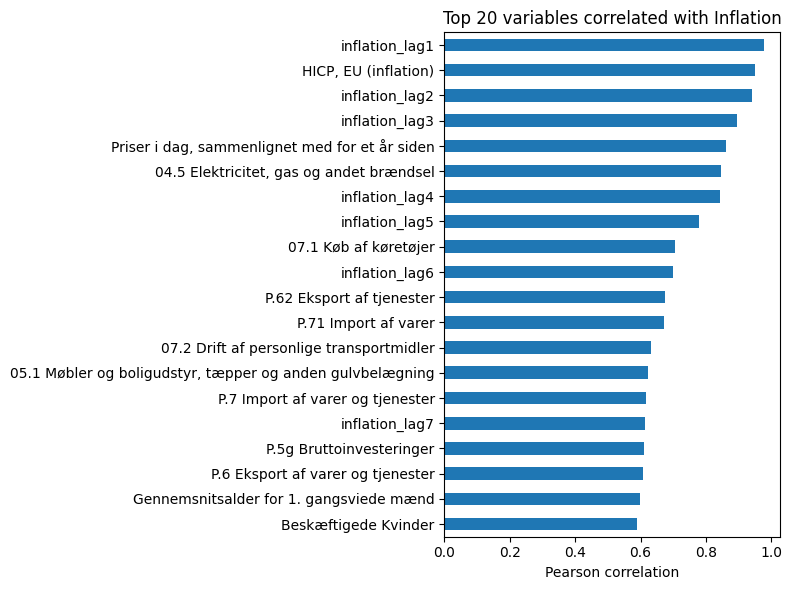

In [121]:
corr_with_inflation = df_merged.corr()["Inflation"].sort_values(ascending=False)
top_corr = corr_with_inflation.drop("Inflation").head(20)

plt.figure(figsize=(8, 6))
top_corr.plot(kind="barh")
plt.title("Top 20 variables correlated with Inflation")
plt.xlabel("Pearson correlation")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


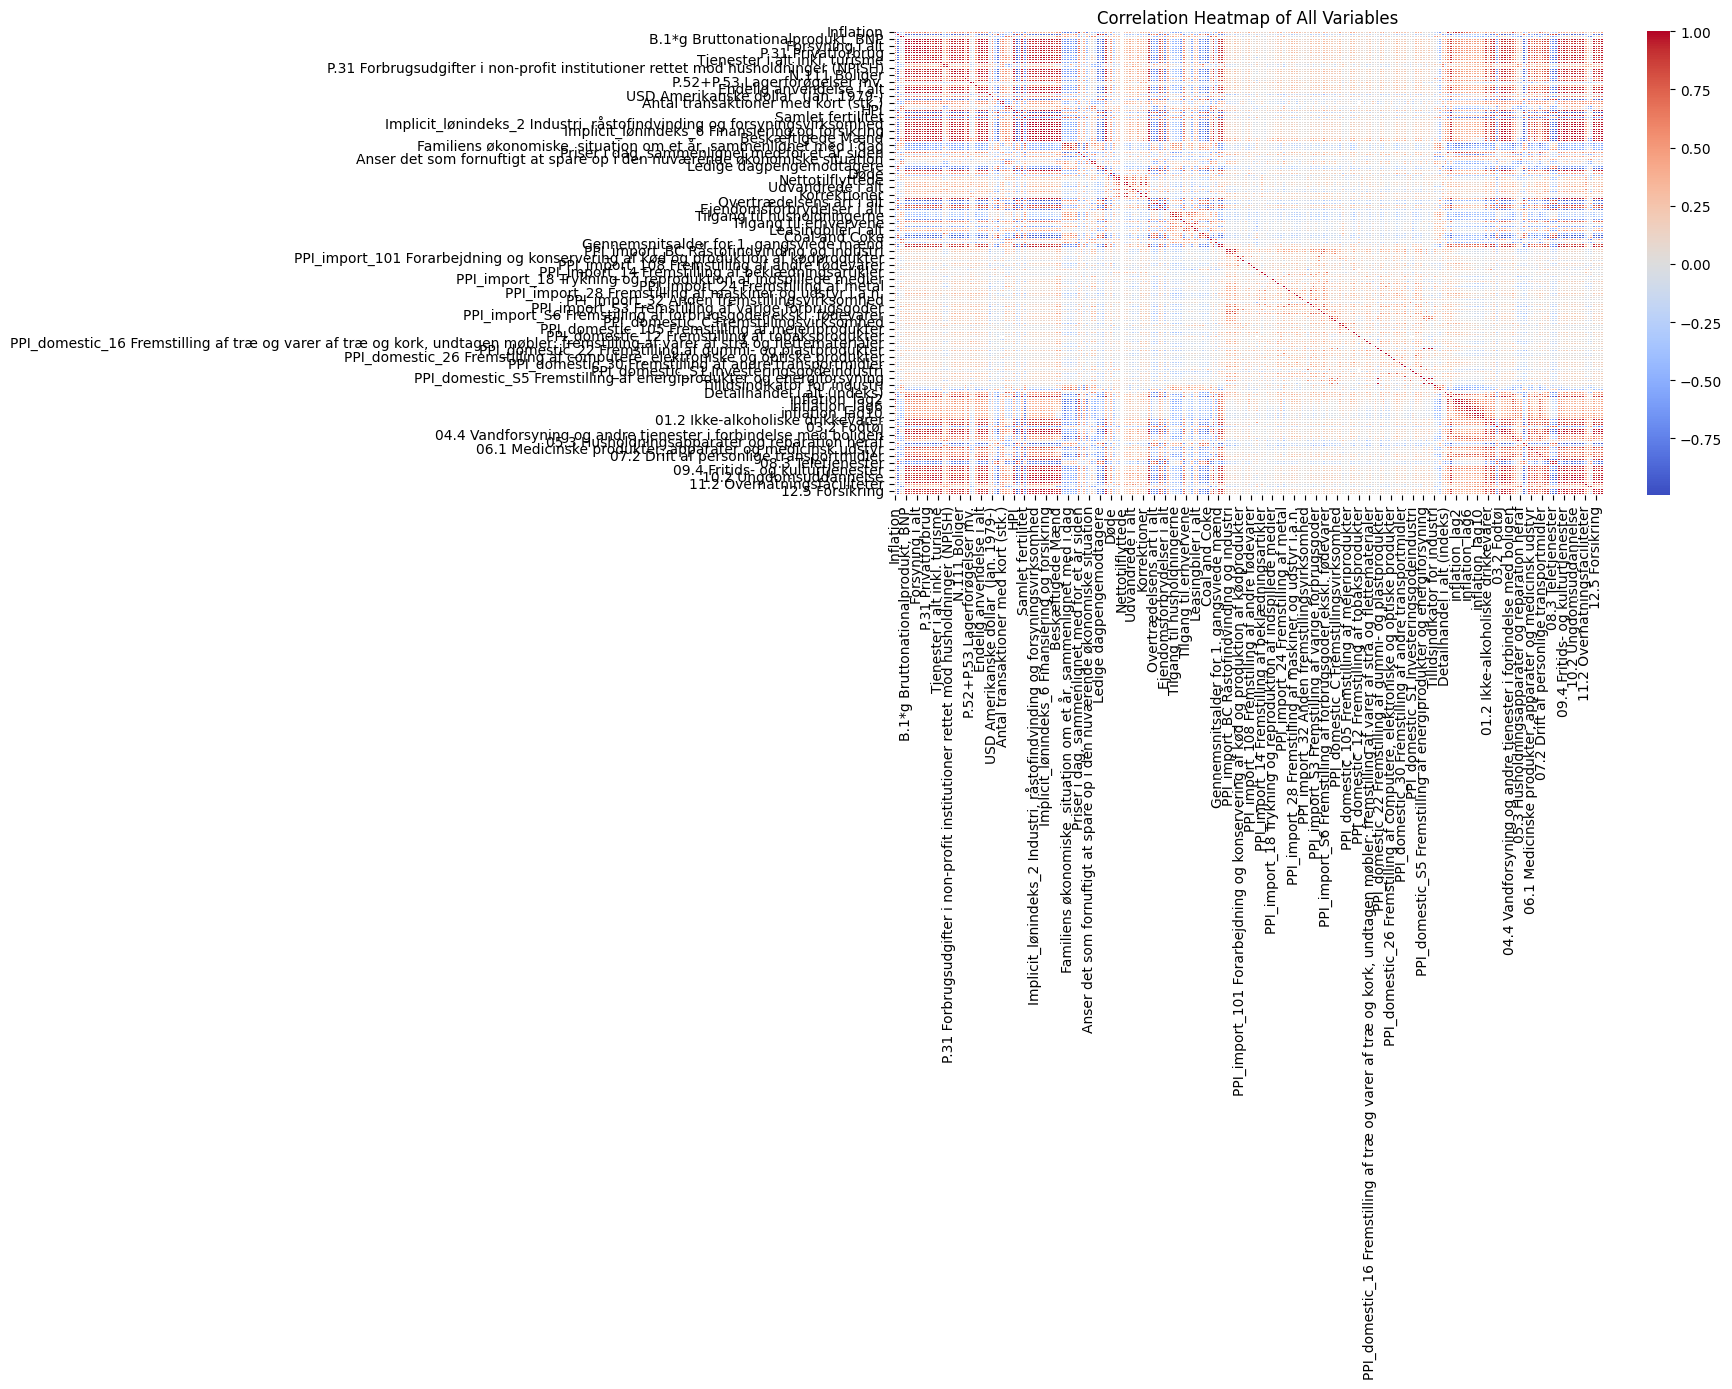

In [122]:
# Beregn korrelationsmatrix
corr_matrix = df_merged.corr()

# Plot heatmap
plt.figure(figsize=(18, 14))  # Tilpas størrelsen efter behov
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Heatmap of All Variables")
plt.tight_layout()
plt.show()

In [123]:
#sns.clustermap(corr_matrix, cmap="coolwarm", figsize=(15, 15))

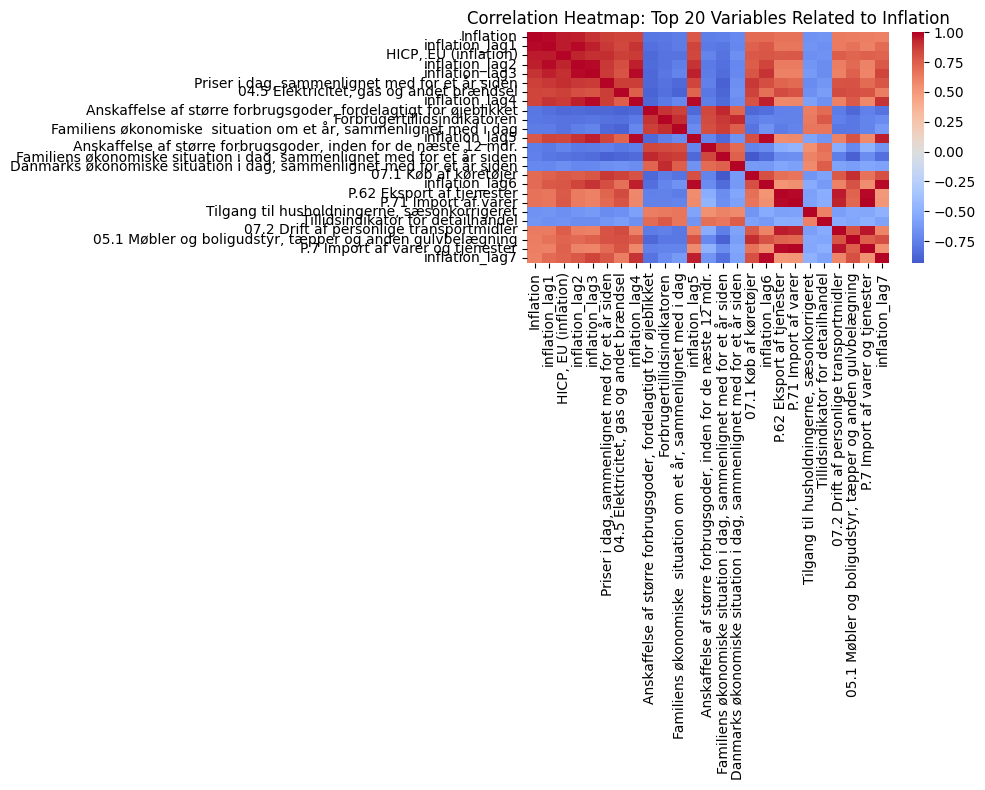

In [124]:
# Top 20 features correlated with 'Inflation'
target = "Inflation"
top_corr_vars = df_merged.corr()[target].abs().sort_values(ascending=False).head(25).index  # incl. 'Inflation'
subset_corr = df_merged[top_corr_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(subset_corr, fmt=".2f", cmap="coolwarm", center=0) # annot=True
plt.title("Correlation Heatmap: Top 20 Variables Related to Inflation")
plt.tight_layout()
plt.show()


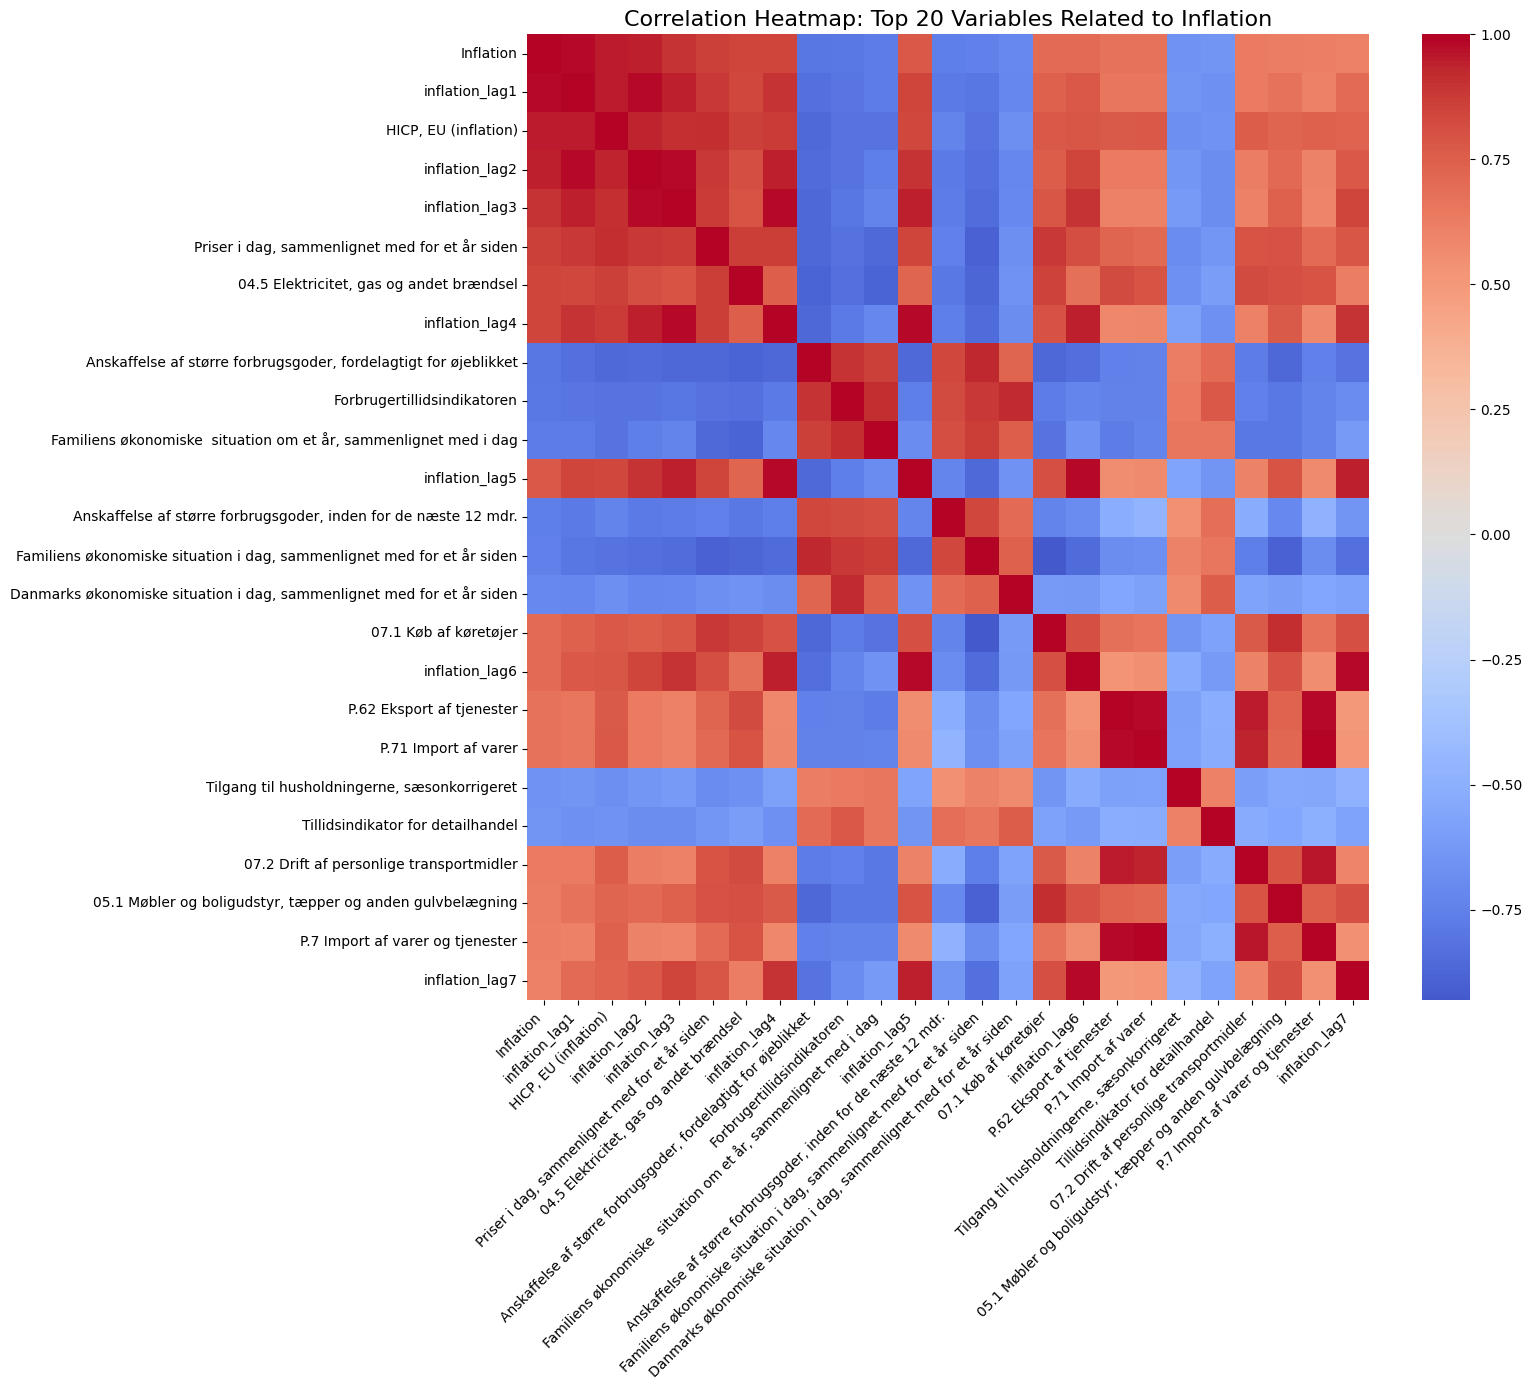

In [125]:
plt.figure(figsize=(16, 14))  # Øg bredde og højde
sns.heatmap(subset_corr, cmap="coolwarm", center=0)

plt.title("Correlation Heatmap: Top 20 Variables Related to Inflation", fontsize=16)

# Roter x-labels og y-labels
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
#plt.savefig('')
plt.show()